In [ ]:
 !pip install aicsimageio==3.3.1

In [1]:
from aicsimageio import imread
from aicsimageio.readers import CziReader
from skimage.filters import threshold_otsu
from skimage.exposure import adjust_gamma, is_low_contrast
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import napari
import numpy as np
import numpy.ma as ma
import subprocess 
import os, sys

In [2]:
%gui qt

In [3]:


# Path to CZI File
#FILE_PATH = "/mnt/5404b8a5-71b7-4464-9a1e-b40cd26fac58/Data_Drive/Wissam/Dendrite_Movies/Cell_351-WT-Green_Channel_Just_ECF_at_0_minutes_DIV19.czi"
FILE_PATH = '/home/peter/Downloads/Cell 368-WT.tif'
# Cell's ID
CELL_ID = "Cell_368-WT"

# Path to ilastik launch script
ILASTIK_LOC = '/home/peter/Applications/ilastik-1.3.3post3-Linux/run_ilastik.sh'

#  Path to ilastik classifier project
ILASTIK_PRO = 'neuron_classifier.ilp'

SEG_DIC = {0:"Background",
          1:"Soma",
          2:"Dendrites"
         }
HZ = 10

In [4]:
if FILE_PATH[-3:] == 'czi':
    print('CZI File Format')
    Czi_File = CziReader(FILE_PATH)
    movie = Czi_File.data[0,:,0,:,:]
    del Czi_File

if FILE_PATH[-3:] == ('tif' or 'iff'):
    print('TIF File Format')
    movie = imread(FILE_PATH)
    movie = movie[0,:,0,0,:,:]

TIF File Format


In [9]:
max_project = np.max(movie, axis=0)
brighter = adjust_gamma(max_project, gamma=.25)
OUTPUT = '%s_Brighter.npy'%(CELL_ID)
np.save(OUTPUT, brighter/brighter.max())


In [10]:
launch_args = [ILASTIK_LOC,
               '--headless',
               '--project='+ILASTIK_PRO,
               '--export_source=probabilities',
               OUTPUT]
subprocess.run(launch_args)

CompletedProcess(args=['/home/peter/Applications/ilastik-1.3.3post3-Linux/run_ilastik.sh', '--headless', '--project=neuron_classifier.ilp', '--export_source=probabilities', 'Cell_368-WT_Brighter.npy'], returncode=0)

In [11]:
pixel_classifier = h5py.File('%s_Brighter_Probabilities.h5'%(CELL_ID))
classes = pixel_classifier['exported_data']


/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


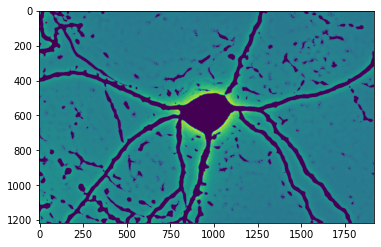

45.73242


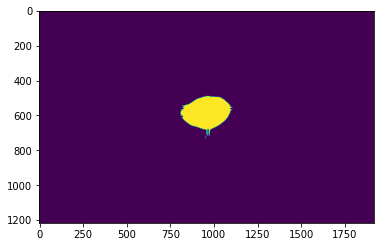

40.776093


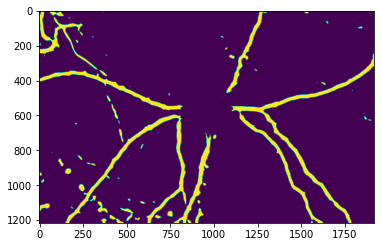

In [12]:

labels = np.zeros(max_project.shape)
label = 0

for i in range(classes.shape[2]):
    class_mask = classes[:,:,i].copy()
    class_mask[class_mask<.75]=0
    test= max_project*class_mask
    if i is not 0:
        test = brighter * class_mask
        threshold =threshold_otsu(test)
        print(threshold)
        test[test<threshold]=0
        test[test>threshold]=1
        labels[test>0]=label
    label+=1
    plt.imshow(test)
    plt.show()

In [ ]:
# Generates ROIs
# 0  - Background
# 1 - Soma
# 2 - Dendrites
labels = np.zeros(max_project.shape)
label = 0
for i in range(classes.shape[2]):
    print(i)
    labels[classes[:,:,i]>.60]=label
    label+=1
plt.imshow(labels)

In [ ]:
# Clean up stuff from memory
del test
del classes
del pixel_classifier

In [ ]:
# Labels can be edited in the Napari window
viewer = napari.view_image(movie, name='movie')
viewer.add_labels(labels, name='Segments')

In [ ]:
if os.path.exists('Output_Traces') == False:
        os.makedirs('Output_Traces')

In [ ]:


for i in (np.unique(labels)):
    if i !=0:
        trace_movie = movie.copy()
        trace_movie = np.broadcast_to(labels==i, trace_movie.shape)
        trace_movie.setflags(write=1)
        trace_movie[trace_movie !=0]=1
        trace_movie = movie*trace_movie

        mask_arr = trace_movie==0

        mx = ma.masked_array(trace_movie, mask=mask_arr)
        mean = mx.mean(axis=(1,2))
        print("Ca2+ Trace for the %s" %SEG_DIC[i])
        plt.plot(mean)
        plt.show()
      
        np.savetxt("Output_Traces/{0}_{1}.csv".format(CELL_ID, SEG_DIC[i]), mean, delimiter="," )
        del trace_movie
        del mask_arr
        del mx
       
        